In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
import numpy as np
import time

import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"

2023-08-12 10:57:59.792859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 10:58:00.752200: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-12 10:58:01.041484: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-12 10:58:03.048881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

In [3]:
def plot(t,s, name, title):

    plt.rcParams.update({'font.size': 14})
    plt.plot(t, s)
    plt.title(title)
    plt.xlabel("Number of samples per sequence")
    plt.ylabel("Percentage of correct explanation values")
    
    plt.savefig(name)

    plt.show()

In [4]:
def generate_sample(sap, nean, den):
    list_before =  list(np.random.choice(sapiens_500_generated, sap)) + list(np.random.choice(neanderthals_500_generated, nean)) + list(np.random.choice(denisovan_500_samples, den))
    l = []
    for i in list_before:
        l.append(str(i))
    return l

In [5]:
from itertools import combinations

def find_all_subsets(group):
    all_subsets = []
    n = len(group)
    
    for r in range(n + 1):
        subsets_r = combinations(group, r)
        all_subsets.extend(list(subsets_r))
        
    return all_subsets

In [6]:
def calculate_shapley_values_for_datum(data_point, length_of_data, ml_calculator):
    indexes_without_datum = [i for i in range(length_of_data) if i != data_point]
    all_subsets = find_all_subsets(indexes_without_datum)
    sum_over_all_subsets = 0 
    for G in all_subsets:
        g_with = [i for i in G]
        g_with.append(data_point)
        with_datum = ml_calculator.calc_maximum_likelihood_on_subset(subset_of_indexes=g_with).values[0]
        without_datum = ml_calculator.calc_maximum_likelihood_on_subset(subset_of_indexes=G).values[0]
        with_minus_without = with_datum - without_datum
        multiplier = np.math.factorial(len(G)) * np.math.factorial(length_of_data - len(G) - 1)
        value_for_sum = with_minus_without * multiplier 
        sum_over_all_subsets += value_for_sum
    shapleys = sum_over_all_subsets / np.math.factorial(length_of_data)
    return  shapleys

In [7]:
def calculate_l_1_distance(vector_a, vector_b):
    a = np.array(vector_a)
    b = np.array(vector_b)
    return np.linalg.norm((a - b), ord=1)


In [8]:
def get_highest_dist(vector_a, vector_b):
    a = np.array(vector_a)
    b = np.array(vector_b)
    return np.abs(a-b).max()

In [9]:
def getOrderedValues(values, data_len):
    ordered_values = []
    for i in range(data_len):
        shapley_of_datum = [k[0][i] for k in values]
        ordered_values.append(shapley_of_datum)
    return ordered_values

In [10]:
def number_of_sign_agrees(vector_a, vector_b):
    count = 0
    for i in range(len(vector_a)):
        if (vector_a[i] * vector_b[i] > 0):
            count+=1
    return count

In [ ]:
def accuracy_a_d_s(a_d_s_values, ground_truth):
    count_correct = 0
    count = 0
    for label in range(3):
        first_label_a_d = a_d_s_values[label][0]
        first_label_gt = [i[label] for i in ground_truth]
        for i in range(len(first_label_gt)):
            if(first_label_a_d[i] * first_label_gt[i] > 0):
                count_correct +=1
            count +=1
    return count_correct / count

In [91]:
def calculate_distance_of_shap_and_mc_to_ground_truth_shapleys(data, ground_truth_shapleys, sample_sizes):
    results = []
    
    data_size = len(data)
    for sample_size in sample_sizes:
        print(sample_size)
        time_before_shap = time.time()
 
        shaps = maximum_likelihood_calculator_d_1.calculate_shapley_values(sample_size)
        shaps_ordered = getOrderedValues(shaps, len(data))
        
        time_after_shap = time.time()
        
        shapley_values_monte_carlo = maximum_likelihood_calculator_d_1.estimate_shapley_values(number_of_samples_per_read = sample_size)
        mc_ordered = getOrderedValues(shapley_values_monte_carlo, len(data))
        
        time_after_mc = time.time()
        
        time_shap_took = time_after_shap - time_before_shap
        time_mc_took = time_after_mc - time_after_shap
        
        sum_of_distances_shap = 0
        highest_dist_shap = 0
        number_of_sign_agrees_shap = 0
        for i in range(len(data)):
            sum_of_distances_shap += calculate_l_1_distance(shaps_ordered[i], ground_truth_shapleys[i])
            highest_current = get_highest_dist(shaps_ordered[i], ground_truth_shapleys[i])
            if (highest_current > highest_dist_shap):
                highest_dist_shap = highest_current
            number_of_sign_agrees_shap += number_of_sign_agrees(shaps_ordered[i], ground_truth_shapleys[i])
            
        number_of_sign_agrees_mc = 0
        highest_dist_mc = 0
        sum_of_distances_mc = 0
        for i in range(len(data)):
            sum_of_distances_mc += calculate_l_1_distance(mc_ordered[i], ground_truth_shapleys[i])
            highest_current = get_highest_dist(mc_ordered[i], ground_truth_shapleys[i])
            if (highest_current > highest_dist_mc):
                highest_dist_mc = highest_current
            number_of_sign_agrees_mc += number_of_sign_agrees(mc_ordered[i], ground_truth_shapleys[i])
        
        number_of_indexes = data_size * 3
        results.append((sample_size, sum_of_distances_shap, highest_dist_shap, sum_of_distances_mc, highest_dist_mc, time_shap_took, time_mc_took, number_of_sign_agrees_shap/number_of_indexes, number_of_sign_agrees_mc/number_of_indexes))
    return results
    
    

In [92]:
all_results = []

In [96]:
sample_sizes = [1,5,10,20,30,50,100,200,400,600,800,1000]
for trial in range(2):
    sapiens = 4
    neanderthals = 4
    denisovans = 4
    dataset = generate_sample(sapiens, neanderthals, denisovans)
    maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(dataset,
                                                        ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                        ref_sapien_file_names=sapiens_reference_file_names,
                                                        ref_denisovan_file_names=denisovan_reference_file_names,
                                                        path_to_substitution_matrix=path_to_frequencies_table,
                                                        number_of_jobs=-1)
    print("starting to calculate ground truth shapleys")
    ground_truth_shapleys = []

    for i in range(len(dataset)):
        print(i)
        ground_truth_shapleys.append(calculate_shapley_values_for_datum(i,len(dataset),maximum_likelihood_calculator_d_1))
    print("ground  truth shapleys:")
    print(ground_truth_shapleys)
    results_current = calculate_distance_of_shap_and_mc_to_ground_truth_shapleys(dataset, ground_truth_shapleys, sample_sizes)
    all_results = all_results + results_current
    print(all_results)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  12
start working on read number 0
starting to calculate ground truth shapleys
0
1
2
3
4
5
6
7
8
9
10
11
ground  truth shapleys:
[array([-3.96825397e-05,  1.09841270e-01, -1.09801587e-01]), array([ 0.42      , -0.24251984, -0.17748016]), array([-0.0275 , -0.02125,  0.04875]), array([-0.0275 , -0.02125,  0.04875]), array([-0.04867063,  0.19052579, -0.14185516]), array([-0.11950397,  0.24021825, -0.12071429]), array([ 0.01243056,  0.13747024, -0.14990079]), array([-0.11117063,  0.2409623 , -0.12979167]), array([-0.11083333, -0.13357143,  0.24440476]), array([-0.0303869 , -0.03196429,  0.06235119]), array([-0.11734127, -0.14656746,  0.26390873]), array([ 0.08051587, -0.20189484,  0.12137897])]
1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1
5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
200
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
400
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
600
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
800
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
1000
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
[(1, 4.443015873015872, 0.42, 3.9323214285714285, 0.5325297619047619, 0.9676532745361328, 0.4947483539581299, 0.0, 0.5), (5, 5.626964285714285, 0.6298015873015873, 2.7617103174603175, 0.2741984126984127, 1.0011882781982422, 2.5541460514068604, 0.1111111111111111, 0.9722222222222222), (10, 3.3890277777777778, 0.2639087301587302, 1.7712063492063497, 0.1714801587301587, 1.0189135074615479, 4.998800039291382, 0.2777777777777778, 0.8333333333333334), (20, 5.308603592314116, 0.4832500000000006, 0.8407976190476191, 0.06902579365079362, 1.1065828800201416, 10.61689567565918, 0.4722222222222222, 1.0), (30, 2.446025751820906, 0.5270146212847554, 0.8542579365079361, 0.07915873015873016, 1.1619789600372314, 14.858620882034302, 0.6944444444444444, 1.0), (50, 1.788778537949271, 0.14695779235005074, 0.718326984126984, 0.05399999999999994, 1.3303864002227783, 26.010924339294434, 0.8055555555555556, 0.9722222222222222), (100, 0.8278007856579709, 0.06198424365280156, 0.46897698412698396, 0.041658

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
200
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
400
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
600
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
800
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
1000
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
[(1, 4.443015873015872, 0.42, 3.9323214285714285, 0.5325297619047619, 0.9676532745361328, 0.4947483539581299, 0.0, 0.5), (5, 5.626964285714285, 0.6298015873015873, 2.7617103174603175, 0.2741984126984127, 1.0011882781982422, 2.5541460514068604, 0.1111111111111111, 0.9722222222222222), (10, 3.3890277777777778, 0.2639087301587302, 1.7712063492063497, 0.1714801587301587, 1.0189135074615479, 4.998800039291382, 0.2777777777777778, 0.8333333333333334), (20, 5.308603592314116, 0.4832500000000006, 0.8407976190476191, 0.06902579365079362, 1.1065828800201416, 10.61689567565918, 0.4722222222222222, 1.0), (30, 2.446025751820906, 0.5270146212847554, 0.8542579365079361, 0.07915873015873016, 1.1619789600372314, 14.858620882034302, 0.6944444444444444, 1.0), (50, 1.788778537949271, 0.14695779235005074, 0.718326984126984, 0.05399999999999994, 1.3303864002227783, 26.010924339294434, 0.8055555555555556, 0.9722222222222222), (100, 0.8278007856579709, 0.06198424365280156, 0.46897698412698396, 0.041658

In [97]:
all_results

[(1,
  4.443015873015872,
  0.42,
  3.9323214285714285,
  0.5325297619047619,
  0.9676532745361328,
  0.4947483539581299,
  0.0,
  0.5),
 (5,
  5.626964285714285,
  0.6298015873015873,
  2.7617103174603175,
  0.2741984126984127,
  1.0011882781982422,
  2.5541460514068604,
  0.1111111111111111,
  0.9722222222222222),
 (10,
  3.3890277777777778,
  0.2639087301587302,
  1.7712063492063497,
  0.1714801587301587,
  1.0189135074615479,
  4.998800039291382,
  0.2777777777777778,
  0.8333333333333334),
 (20,
  5.308603592314116,
  0.4832500000000006,
  0.8407976190476191,
  0.06902579365079362,
  1.1065828800201416,
  10.61689567565918,
  0.4722222222222222,
  1.0),
 (30,
  2.446025751820906,
  0.5270146212847554,
  0.8542579365079361,
  0.07915873015873016,
  1.1619789600372314,
  14.858620882034302,
  0.6944444444444444,
  1.0),
 (50,
  1.788778537949271,
  0.14695779235005074,
  0.718326984126984,
  0.05399999999999994,
  1.3303864002227783,
  26.010924339294434,
  0.8055555555555556,
  0.9

In [98]:
all_results = all_results + results_1

In [99]:
all_results

[(1,
  4.443015873015872,
  0.42,
  3.9323214285714285,
  0.5325297619047619,
  0.9676532745361328,
  0.4947483539581299,
  0.0,
  0.5),
 (5,
  5.626964285714285,
  0.6298015873015873,
  2.7617103174603175,
  0.2741984126984127,
  1.0011882781982422,
  2.5541460514068604,
  0.1111111111111111,
  0.9722222222222222),
 (10,
  3.3890277777777778,
  0.2639087301587302,
  1.7712063492063497,
  0.1714801587301587,
  1.0189135074615479,
  4.998800039291382,
  0.2777777777777778,
  0.8333333333333334),
 (20,
  5.308603592314116,
  0.4832500000000006,
  0.8407976190476191,
  0.06902579365079362,
  1.1065828800201416,
  10.61689567565918,
  0.4722222222222222,
  1.0),
 (30,
  2.446025751820906,
  0.5270146212847554,
  0.8542579365079361,
  0.07915873015873016,
  1.1619789600372314,
  14.858620882034302,
  0.6944444444444444,
  1.0),
 (50,
  1.788778537949271,
  0.14695779235005074,
  0.718326984126984,
  0.05399999999999994,
  1.3303864002227783,
  26.010924339294434,
  0.8055555555555556,
  0.9

In [110]:
l_1_shap = [(i[0],i[1]) for i in all_results]

In [122]:
def return_avg(list_of_sizes):
    to_ret = []
    for size in sample_sizes:
        cur = [i[1] for i in list_of_sizes if i[0] == size]
        to_ret.append(np.mean(cur))
    return to_ret

In [112]:
l_1_mc = [(i[0],i[3]) for i in all_results]

In [113]:
largest_distance_shap = [(i[0], i[2]) for i in all_results]
largest_distance_mc = [(i[0], i[4]) for i in all_results]

In [114]:
time_shap = [(i[0], i[5]) for i in all_results]
time_mc = [(i[0], i[6]) for i in all_results]

In [115]:
sign_accuracy_shap = [(i[0], i[7]) for i in all_results]
sign_accuracy_mc = [(i[0], i[8]) for i in all_results]

In [116]:
plt.figure() 
plt.figure().clear()
plt.rcParams.update({'font.size': 14})
t = [i  for i in sample_sizes]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [121]:
return_avg(l_1_shap)

[4.456566257816258,
 5.022922077922078,
 3.983326839826839,
 4.73632403807866,
 2.5004559020058803,
 1.788963108111388,
 0.8188433534053892,
 0.43313256278030154,
 0.3744928982006838,
 0.2955497208002751,
 0.2936890279784648,
 0.22958778974772956]

In [120]:
return_avg(l_1_mc)

[4.456566257816258,
 5.022922077922078,
 3.983326839826839,
 4.73632403807866,
 2.5004559020058803,
 1.788963108111388,
 0.8188433534053892,
 0.43313256278030154,
 0.3744928982006838,
 0.2955497208002751,
 0.2936890279784648,
 0.22958778974772956]

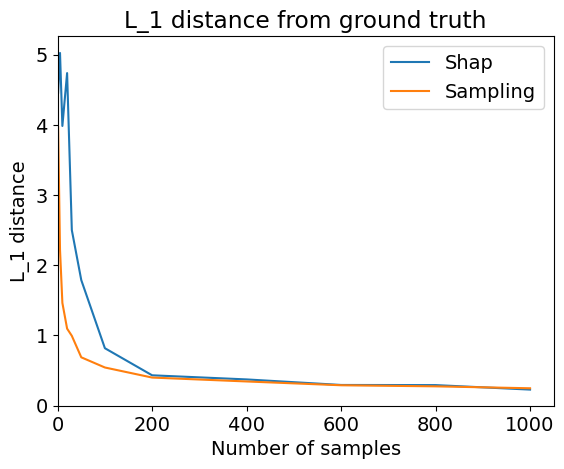

In [123]:
plt.plot(t,return_avg(l_1_shap),label='Shap')
plt.plot(t,return_avg(l_1_mc),label='Sampling')
plt.title("L_1 distance from ground truth")
plt.xlabel("Number of samples")
plt.ylabel("L_1 distance")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.savefig("l_1_distance.png")
plt.show()

In [87]:
plt.figure() 
plt.figure().clear()
plt.rcParams.update({'font.size': 14})


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

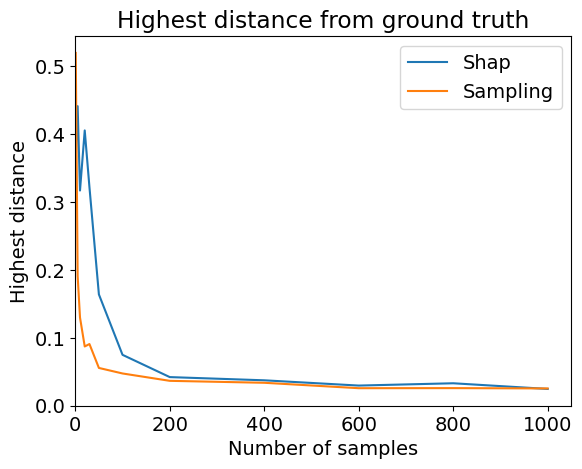

In [124]:
plt.plot(t,return_avg(largest_distance_shap),label='Shap')
plt.plot(t,return_avg(largest_distance_mc),label='Sampling')
plt.title("Highest distance from ground truth")
plt.xlabel("Number of samples")
plt.ylabel("Highest distance")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.savefig("highest_distance.png")
plt.show()

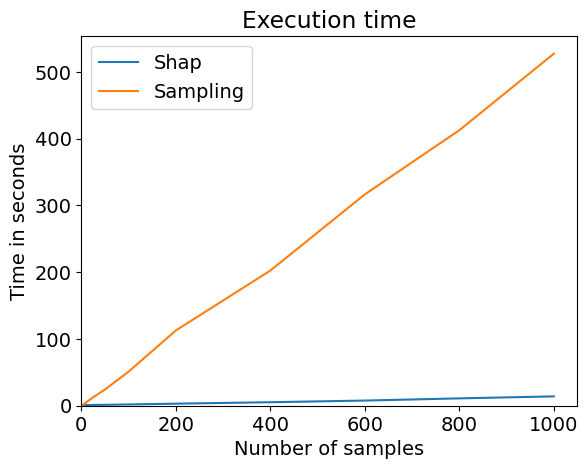

In [125]:
plt.plot(t,return_avg(time_shap),label='Shap')
plt.plot(t,return_avg(time_mc),label='Sampling')
plt.title("Execution time")
plt.xlabel("Number of samples")
plt.ylabel("Time in seconds")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.savefig("execution_time.png")
plt.show()

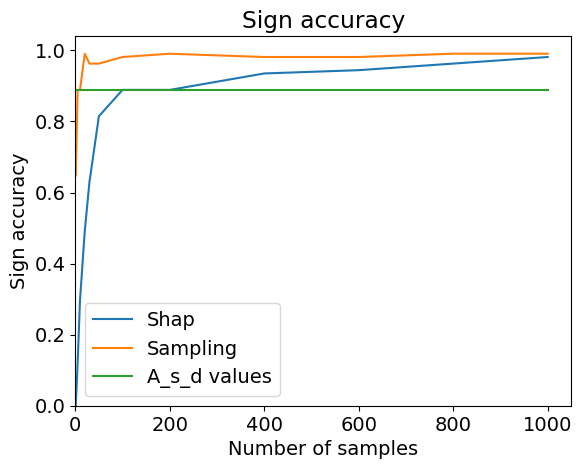

In [127]:
a_s_d = maximum_likelihood_calculator_d_1.get_A_s_d_values()
first = [a[0]-0.33 for a in a_s_d ]
second = [a[1]-0.33 for a in a_s_d ]
thirs = [a[2]-0.33 for a in a_s_d ]
a_s_d_values = [[first], [second], [thirs]]
sign_accuracy_a_s_d = accuracy_a_d_s(a_s_d_values, ground_truth_shapleys)
sign_acc_a_d_s_list = [sign_accuracy_a_s_d for i in range(len(t))]
plt.plot(t,return_avg(sign_accuracy_shap),label='Shap')
plt.plot(t,return_avg(sign_accuracy_mc),label='Sampling')
plt.plot(t,sign_acc_a_d_s_list,label='A_s_d values')
plt.title("Sign accuracy")
plt.xlabel("Number of samples")
plt.ylabel("Sign accuracy")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.savefig("sign_accuracy.png")
plt.show()

In [128]:
ground_truth_shapleys

[array([ 0.10645202, -0.15944174,  0.05298972]),
 array([ 0.37756674, -0.2010588 , -0.17650794]),
 array([-0.03117424, -0.02041667,  0.05159091]),
 array([ 0.00143579,  0.15605429, -0.15749008]),
 array([ 0.01498737, -0.03248737,  0.0175    ]),
 array([-0.12767136,  0.27142136, -0.14375   ]),
 array([-0.12796898,  0.27171898, -0.14375   ]),
 array([ 0.04806367,  0.1109145 , -0.15897817]),
 array([-0.10511544, -0.11078734,  0.21590278]),
 array([-0.10630231, -0.10960047,  0.21590278]),
 array([-0.0562031 , -0.01448413,  0.07068723]),
 array([-0.09907017, -0.11683261,  0.21590278])]